# Импорт библиотек
Этот блок подключает все необходимые библиотеки. 
- pandas и numpy — для работы с таблицами и числами
- yfinance — чтобы скачать котировки с Yahoo Finance
- plotly — для построения красивых графиков


In [2]:
# Импорт всех нужных библиотек для анализа и графиков
import pandas as pd        # Работа с таблицами
import numpy as np         # Быстрые числовые расчёты
import yfinance as yf      # Скачивание котировок с Yahoo Finance
import plotly.graph_objects as go     # Графики
from plotly.subplots import make_subplots   # Для сложных графиков с несколькими окнами

# Параметры и начальные условия
В этом блоке задаю стартовые настройки стратегии:
- Сколько денег на старте, за какой период брать котировки,
- Какой тикер анализировать, размеры окон для скользящих средних и стоп-лосс.
Все эти параметры удобно менять в одном месте.

In [3]:
# Основные параметры стратегии — меняются тут
money = 1_000_000      # стартовый капитал (например, миллион)
start = '2015-01-01'   # дата начала анализа
finish = '2020-12-31'  # дата конца анализа
stop_loss = 5          # стоп-лосс (максимальная просадка в %)
short_window = 30      # короткая SMA (в днях)
long_window = 90       # длинная SMA (в днях)
ticker = 'AAPL'        # тикер акции (например, Apple — можно сменить на любой)

# Загрузка котировок акций
Скачиваю исторические данные по выбранной бумаге (например, Apple/AAPL) через yfinance.
- Оставляю только нужные столбцы: Open, High, Low, Close.
- Убираю пропуски, убеждаюсь что индекс — это даты.
Это исходная база для всех дальнейших вычислений.

In [4]:
# Скачиваю котировки выбранной акции с Yahoo
df = yf.download(ticker, start=start, end=finish)
# Оставляю только нужные столбцы — Open, High, Low, Close
df = df[['Open', 'High', 'Low', 'Close']].dropna()
# Перевожу индекс в формат даты (на всякий случай)
df.index = pd.to_datetime(df.index)
# Смотрю на первые строки, чтобы убедиться, что всё скачалось
df.head()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Open,High,Low,Close
Ticker,AAPL,AAPL,AAPL,AAPL
Date,,,,
2015-01-02,24.746228,24.757336,23.848707,24.288582
2015-01-05,24.057541,24.137518,23.417725,23.604338
2015-01-06,23.668754,23.866475,23.244431,23.606550
2015-01-07,23.815387,24.037545,23.704307,23.937574
2015-01-08,24.266367,24.915069,24.148621,24.857307


# Вычисление скользящих средних
В этом блоке считаю короткую и длинную скользящие средние (SMA).
- Короткая реагирует быстрее, длинная — медленнее.
- Эти средние помогут определить сигналы на покупку/продажу.

In [5]:
# Считаю скользящие средние:
# Короткая реагирует быстрее, длинная — медленнее
df['SMA_short'] = df['Close'].rolling(window=short_window).mean()   # короткая SMA
df['SMA_long'] = df['Close'].rolling(window=long_window).mean()     # длинная SMA
# Смотрю, как получились средние
df[['Close', 'SMA_short', 'SMA_long']].tail()

Price,Close,SMA_short,SMA_long
Ticker,AAPL,,
Date,,,
2020-12-23,127.751717,119.102269,115.588228
2020-12-24,128.737000,119.508078,115.768224
2020-12-28,133.341324,120.076470,115.997812
2020-12-29,131.565918,120.584056,116.179891
2020-12-30,130.444077,121.020429,116.283556


# Формирование сигналов для торгов
На этом этапе определяю, когда надо покупать или продавать:
- Если короткая SMA пересекает длинную снизу вверх — покупаем.
- Если сверху вниз — продаём.
- Делаю новую колонку с сигналами.

In [6]:
# Формирую сигналы:
# Если короткая SMA выше длинной — отмечаю 1, иначе 0
df['crossover'] = np.where(df['SMA_short'] > df['SMA_long'], 1, 0)
# Считаю разницу по дням: если стало 1 — был переход снизу вверх (покупка), -1 — сверху вниз (продажа)
df['signal_raw'] = df['crossover'].diff()
# Смотрю, где появляются сигналы
df[['Close', 'SMA_short', 'SMA_long', 'signal_raw']].tail(15)

Price,Close,SMA_short,SMA_long,signal_raw
Ticker,AAPL,,,
Date,,,,
2020-12-09,118.796608,114.830932,113.987256,0.0
2020-12-10,120.220833,115.228660,114.138577,0.0
2020-12-11,119.411171,115.465662,114.276608,0.0
2020-12-14,118.796608,115.891875,114.366336,0.0
2020-12-15,124.747177,116.519361,114.550152,0.0
2020-12-16,124.678902,117.090362,114.715734,0.0
2020-12-17,125.547081,117.543904,114.927238,0.0
2020-12-18,123.557053,117.798673,115.077299,0.0


# Симуляция сделок — вся логика торговли
Здесь проходит вся основная логика робота:
- Перебираю все дни по очереди.
- Реагирую на сигналы: покупаю/продаю/ставлю стоп-лосс.
- Считаю, сколько акций купил/продал, сколько осталось денег.
Результаты каждого действия заношу в events — потом строю отчёт.

In [7]:
# Симуляция торговли — здесь вся логика покупок/продаж
events = []                  # Список событий: сюда пишу все сделки и действия
cash = money                 # Деньги на руках
num_shares = 0               # Количество акций на руках
stop_price = None            # Текущий уровень стоп-лосса (если есть)

for i in range(len(df) - 1):   # Проходим по всем дням (кроме последнего)
    today = df.index[i]                            # Текущая дата
    sig_val = float(df['signal_raw'].iloc[i])      # Сигнал на сегодня: 1, -1 или 0
    low_val = float(df['Low'].iloc[i])             # Минимальная цена дня
    open_val = float(df['Open'].iloc[i])           # Цена открытия дня
    next_day = df.index[i + 1]                     # Следующий день
    next_open = float(df['Open'].iloc[i + 1])      # Цена открытия на следующий день

    # 1. Проверяю — не сработал ли стоп-лосс
    if num_shares > 0 and stop_price is not None and low_val <= float(stop_price):
        sale_val = num_shares * float(stop_price)      # Сколько денег получу по стоп-цене
        cash += sale_val                              # Обновляю деньги на счёте
        events.append({'date': today.strftime('%Y-%m-%d'),
                       'signal': 'stop-loss',
                       'num_shares': num_shares,
                       'share_price': float(stop_price),
                       'share_value': num_shares * float(stop_price),
                       'cash': round(cash, 2)})
        num_shares = 0          # Акций больше нет
        stop_price = None       # Сбрасываю стоп-лосс
        continue                # Перехожу к следующему дню

    # 2. Если сигнал на покупку — отмечаю событие и покупаю на следующий день
    if sig_val == 1:
        events.append({'date': today.strftime('%Y-%m-%d'),
                       'signal': 'sig_buy',
                       'num_shares': num_shares,
                       'share_price': open_val,
                       'share_value': num_shares * open_val,
                       'cash': round(cash, 2)})
        max_affordable = int(cash // next_open)          # Максимум акций, которые могу купить
        if max_affordable > 0:
            cost = max_affordable * next_open
            cash -= cost                                 # Списываю деньги
            num_shares += max_affordable                 # Покупаю акции
            stop_price = next_open * (1 - stop_loss / 100)  # Устанавливаю новый стоп-лосс
            events.append({'date': next_day.strftime('%Y-%m-%d'),
                           'signal': 'buy',
                           'num_shares': num_shares,
                           'share_price': next_open,
                           'share_value': num_shares * next_open,
                           'cash': round(cash, 2)})
    # 3. Если сигнал на продажу и есть акции — отмечаю событие и продаю на следующий день
    elif sig_val == -1 and num_shares > 0:
        events.append({'date': today.strftime('%Y-%m-%d'),
                       'signal': 'sig_sale',
                       'num_shares': num_shares,
                       'share_price': open_val,
                       'share_value': num_shares * open_val,
                       'cash': round(cash, 2)})
        sale_val = num_shares * next_open
        cash += sale_val
        events.append({'date': next_day.strftime('%Y-%m-%d'),
                       'signal': 'sale',
                       'num_shares': num_shares,
                       'share_price': next_open,
                       'share_value': 0.0,
                       'cash': round(cash, 2)})
        num_shares = 0
        stop_price = None

# Преобразую события в DataFrame — это и есть финальный торговый отчёт
report = pd.DataFrame(events)
report.head()

C:\Users\gserb\AppData\Local\Temp\ipykernel_26764\3046056599.py:10: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  low_val = float(df['Low'].iloc[i])             # Минимальная цена дня
C:\Users\gserb\AppData\Local\Temp\ipykernel_26764\3046056599.py:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  open_val = float(df['Open'].iloc[i])           # Цена открытия дня
C:\Users\gserb\AppData\Local\Temp\ipykernel_26764\3046056599.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  next_open = float(df['Open'].iloc[i + 1])      # Цена открытия на следующий день


,date,signal,num_shares,share_price,share_value,cash
0,2015-05-12,sig_buy,0,28.130234,0.000000,1000000.00
1,2015-05-13,buy,35393,28.253414,999973.098257,26.90
2,2015-07-09,stop-loss,35393,26.840744,949974.443344,950001.35
3,2015-11-17,sig_buy,0,25.965444,0.000000,950001.35
4,2015-11-18,buy,36321,26.155239,949984.441588,16.90


# Подсчёт итогов стратегии
В этом блоке считаю конечный результат:
- Если остались акции — прибавляю их стоимость к кэшу.
- Считаю общий доход/убыток в процентах.
Вывожу итоговые показатели стратегии.

In [8]:
# Считаю финальную стоимость портфеля
# Если остались акции — их считаю по последней цене
if num_shares > 0:
    last_price = float(df['Close'].iloc[-1])
    final_value = float(cash) + num_shares * last_price
else:
    final_value = float(cash)
# Считаю процент изменения капитала
perc_change = (final_value - money) / money * 100
# Красиво вывожу результат
print(f'Итоговая стоимость портфеля: {final_value:,.2f}')
print(f'Изменение относительно начального капитала: {perc_change:.2f}%')

Итоговая стоимость портфеля: 2,282,563.99
Изменение относительно начального капитала: 128.26%


C:\Users\gserb\AppData\Local\Temp\ipykernel_26764\1889430735.py:4: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  last_price = float(df['Close'].iloc[-1])


# Визуализация результатов
Рисую два основных графика:
- Свечной график цены с наложенными скользящими средними и отметками всех сигналов.
- График позиций: видно, когда стратегия была 'в рынке', а когда в кэше.
Так проще понять, где и как работала стратегия на практике.

C:\Users\gserb\anaconda3\Lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



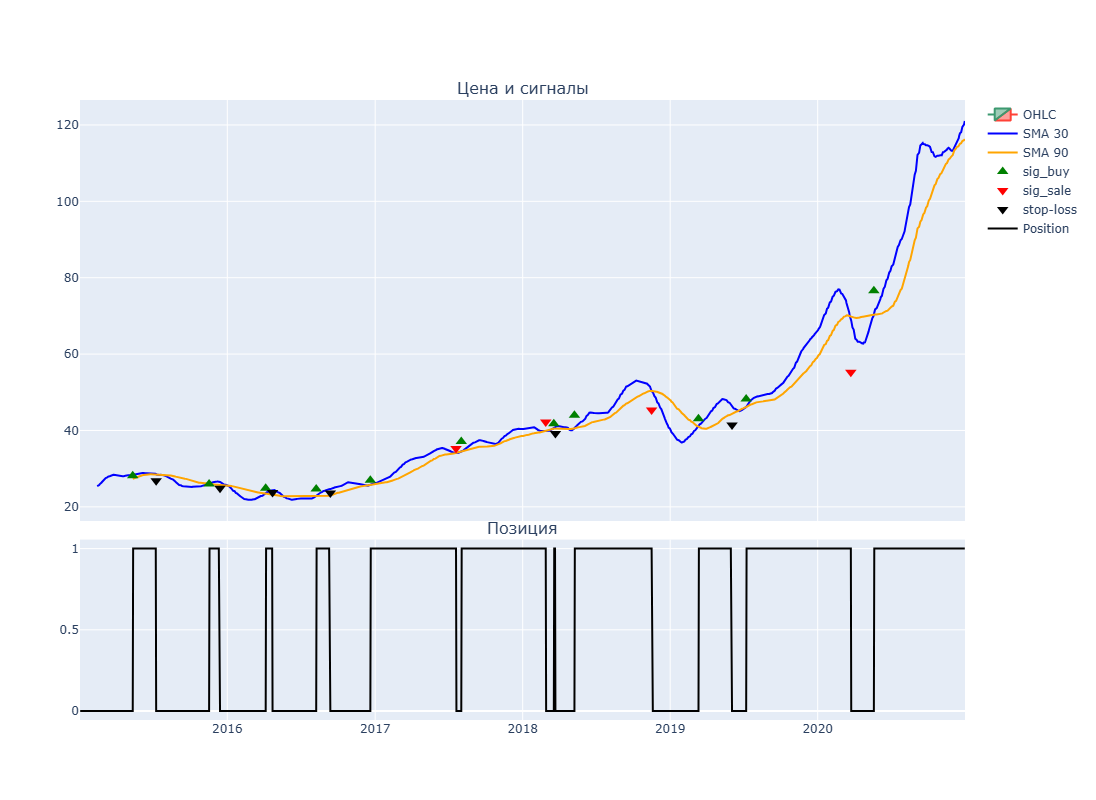

In [19]:
# Перевожу даты в формат datetime, чтобы не было багов с осями
report['date'] = pd.to_datetime(report['date'])
# Ставлю date в индекс, чтобы было удобнее обращаться по датам
report_idx = report.set_index('date')

# Собираю временной ряд: держу я акции или нет на каждом дне
pos = 0    # Сначала я вне позиции (0 — всё в кэше)
flags = [] # Здесь буду хранить результат для каждого дня

# Прохожусь по всем датам из основного датафрейма
for d in df.index:
    # Если сегодня есть сигнал "buy", значит я захожу в позицию
    if d in report_idx[report_idx.signal == 'buy'].index:
        pos = 1
    # Если пришёл сигнал "sale" или "stop-loss" — выхожу из позиции
    elif d in report_idx[report_idx.signal.isin(['sale', 'stop-loss'])].index:
        pos = 0
    # Записываю, что получилось на этот день
    flags.append(pos)

# Делаю Series — теперь для каждой даты знаю, был ли я в акциях (1) или нет (0)
position_series = pd.Series(flags, index=df.index)

# Начинаю строить визуализацию
# Создаю график с двумя окошками: верх — цена+сигналы, низ — позиция (1 или 0)
fig = make_subplots(
    rows=2, cols=1,
    shared_xaxes=True,
    vertical_spacing=0.03,
    row_heights=[0.7, 0.3],
    subplot_titles=("Цена и сигналы", "Позиция")
)

# Добавляю свечи — для наглядности показываю OHLC по дням
fig.add_trace(
    go.Candlestick(
        x=df.index,
        open=df['Open'], high=df['High'],
        low=df['Low'], close=df['Close'],
        name="OHLC"
    ), row=1, col=1
)

# Добавляю короткую скользящую (SMA 30) — синим цветом, чтобы было видно сигналы пересечений
fig.add_trace(
    go.Scatter(
        x=df.index, y=df['SMA_short'],
        mode='lines',
        line=dict(color='blue'),
        name="SMA 30"
    ), row=1, col=1
)

# Добавляю длинную скользящую (SMA 90) — оранжевым, как положено по классике
fig.add_trace(
    go.Scatter(
        x=df.index, y=df['SMA_long'],
        mode='lines',
        line=dict(color='orange'),
        name="SMA 90"
    ), row=1, col=1
)

# Теперь прохожусь по всем типам сигналов — и добавляю на график маркеры для каждого типа:
for sig_type, color, symbol in [
    ('sig_buy',  'green',  'triangle-up'),    # покупка — зелёный ▲
    ('sig_sale', 'red',    'triangle-down'),  # продажа — красный ▼
    ('stop-loss','black',  'triangle-down')   # стоп-лосс — чёрный ▼
]:
    # Фильтрую только нужные сигналы из отчёта
    df_sig = report[report.signal == sig_type]
    # Кидаю маркеры (треугольники) на график цены, строго в нужные точки
    fig.add_trace(
        go.Scatter(
            x=df_sig['date'], y=df_sig['share_price'],
            mode='markers',
            marker=dict(symbol=symbol, color=color, size=10),
            name=sig_type
        ),
        row=1, col=1
    )

# Строю нижний график: тут видно, когда я был в позиции, а когда в кэше (1 или 0)
fig.add_trace(
    go.Scatter(
        x=position_series.index,
        y=position_series.values,
        mode='lines',
        line=dict(color='black'),
        name="Position"
    ),
    row=2, col=1
)

# Оформляю финальные настройки графика (чтобы был красивый и удобный)
fig.update_layout(
    height=800,
    showlegend=True,
    xaxis_rangeslider_visible=False
)

fig.show()
